In [1]:
import _sqlite3
import matplotlib
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, naive_bayes
import sklearn
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [12]:
#Comparison of SVC-Kernels with weighted classes.

nlp = spacy.load("de_core_news_lg")
cnx = _sqlite3.connect("corpus.sqlite3")


In [3]:
# Eventuell notwendige, einmalige Installation der Spacy-Pipeline:
# !python -m spacy download de_core_news_lg

In [4]:
# comments_df = pd.read_sql_query("Select ID_Post, Headline, Body FROM Posts",cnx)
# labels_df = pd.read_sql_query("SELECT * From Annotations_consolidated",cnx)


In [5]:
labels = ["ArgumentsUsed","Discriminating","Inappropriate","OffTopic","PersonalStories","PossiblyFeedback","SentimentNegative","SentimentNeutral","SentimentPositive"]

label_map = {y:x for (x,y) in enumerate(labels)}

In [6]:
def getLabeledPart(label):
    """

    :param label: Das Label, so dass wir alle Posts auswählen, bei denen dieses Label gesetzt ist
    :return: Ein DataFrame mit dem Index ID_Post (als 0. Spalte) und den Spalten 'Text' sowie 'Value'.
             'Value' besagt hierbei für jeden Post, ob das Label zutrifft oder nicht (1 oder 0)
    """
    value_count = pd.read_sql_query("SELECT * "
                                    "FROM Annotations_consolidated "
                                    "WHERE Category = '{}'".format(label),cnx).shape[0]

    # Wir holen uns alle Posts, die gemäß dem Parameter label gelabeled sind
    wanted_join_table = pd.read_sql_query(
        "Select ID_Post, Headline, Body, Value "
        "FROM Posts INNER JOIN Annotations_consolidated USING(ID_Post)"
        "WHERE Annotations_consolidated.Category = '{}'".format(label),cnx)

    assert wanted_join_table.shape[0] == value_count

    # Setzen ID_Post als Index des DataFrames
    wanted_join_table = wanted_join_table.set_index("ID_Post")

    # Fusen von Headline & Body
    for row_ID, cur_row in wanted_join_table.iterrows():
        headline = cur_row["Headline"]
        body = cur_row["Body"]
        if not headline:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["Body"]
        elif not body:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["Headline"]
        else:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["Headline"] +"\n"+ cur_row["Body"]

    wanted_join_table = wanted_join_table.drop("Headline",axis=1).drop("Body",axis=1)

    return wanted_join_table


In [7]:
#Beispiel, wie dann eine solche join_table aussieht:
getLabeledPart(labels[0])

,Value,Text
ID_Post,,
3326,0,Top qualifizierte Leute verdienen auch viel.
5321,1,"Gott sei dank ist für sie eine Umfrage alles, ..."
5590,1,""" Die FPÖ wird aus allen Rohren schießen und d..."
6015,0,Weil es dein meisten Leuten verständlicherweis...
8213,0,Na wer weis was da vorgefallen ist...
...,...,...
1004115,1,Russland ist in wk1 vorzeirig ausgestiegen. ;-...
1004189,0,"Was tendenziell kein schlechter Tausch wäre, w..."
1004571,1,Was? Unsinn! Der Linguistik turn beschränkt si...


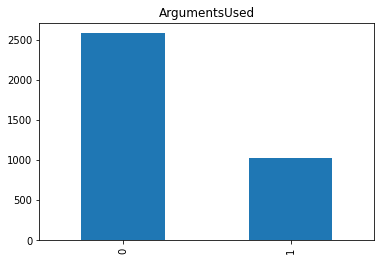

0    2577
1    1022
Name: Value, dtype: int64


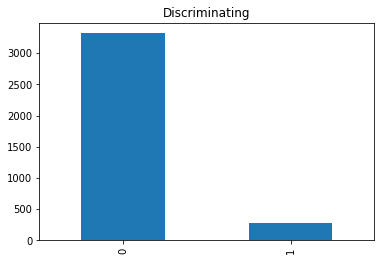

0    3317
1     282
Name: Value, dtype: int64


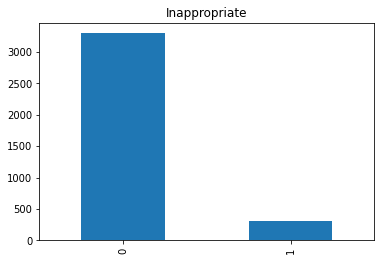

0    3296
1     303
Name: Value, dtype: int64


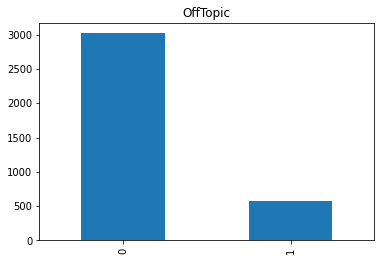

0    3019
1     580
Name: Value, dtype: int64


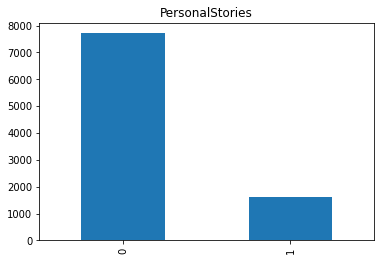

0    7711
1    1625
Name: Value, dtype: int64


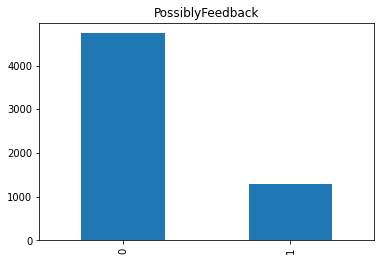

0    4737
1    1301
Name: Value, dtype: int64


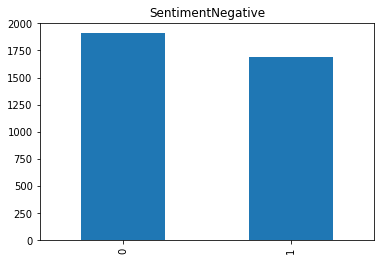

0    1908
1    1691
Name: Value, dtype: int64


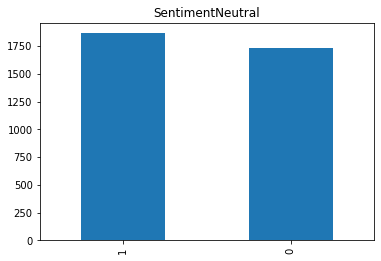

1    1865
0    1734
Name: Value, dtype: int64


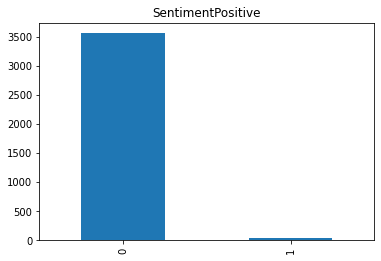

0    3556
1      43
Name: Value, dtype: int64


In [8]:
# Verteilung der Labels:
for label in labels:
    # Table_Join holen:
    joined_table = getLabeledPart(label)
    val_counts = joined_table["Value"].value_counts()
    bar_plot = val_counts.plot.bar(title= label)
    plt.show()
    print(val_counts)

# Man sieht insbesondere, dass 'SentimentPositive' zu wenig positive Instanzen hat, weswegen Training für dieses Label fast zwangsläufig fehlschlägt...

In [9]:
# simplefilter("ignore", category=ConvergenceWarning)

--------------
--------------
Label:    ArgumentsUsed
--------------
2:
Confusion Matrix: 



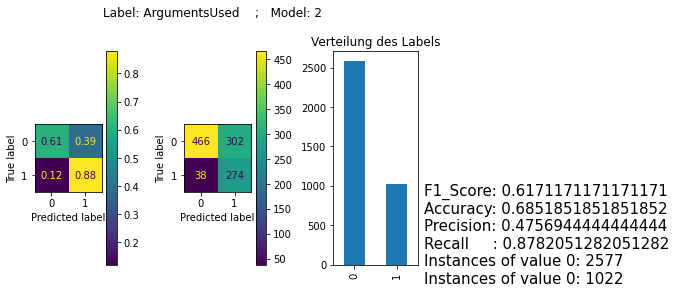

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
3:
Confusion Matrix: 



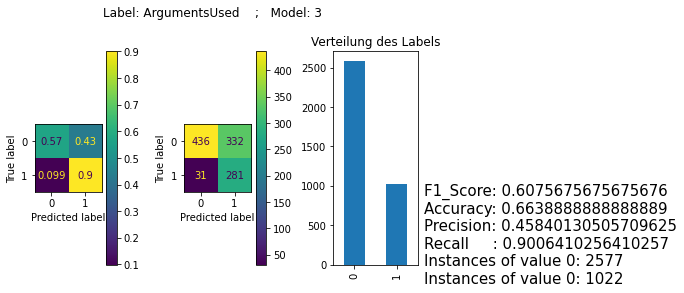

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
4:
Confusion Matrix: 



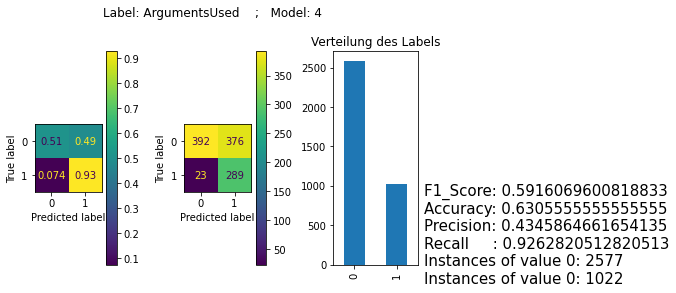

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
5:
Confusion Matrix: 



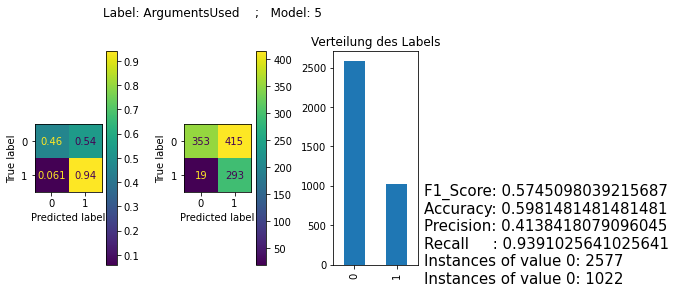

--------------
--------------
--------------
Label:    Discriminating
--------------
2:
Confusion Matrix: 



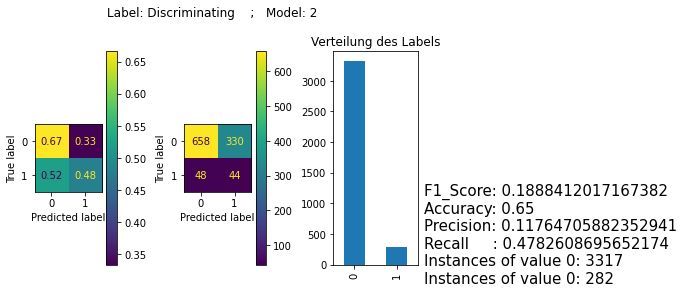

--------------
--------------
--------------
Label:    Discriminating
--------------
3:
Confusion Matrix: 



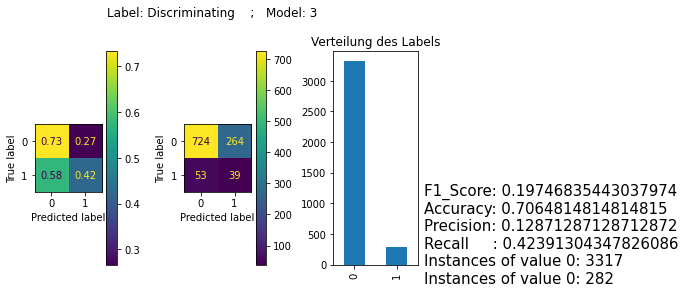

--------------
--------------
--------------
Label:    Discriminating
--------------
4:
Confusion Matrix: 



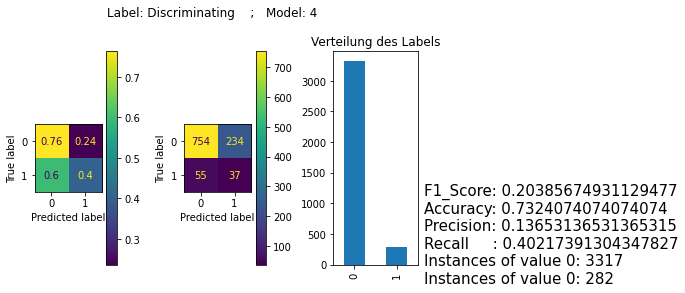

--------------
--------------
--------------
Label:    Discriminating
--------------
5:
Confusion Matrix: 



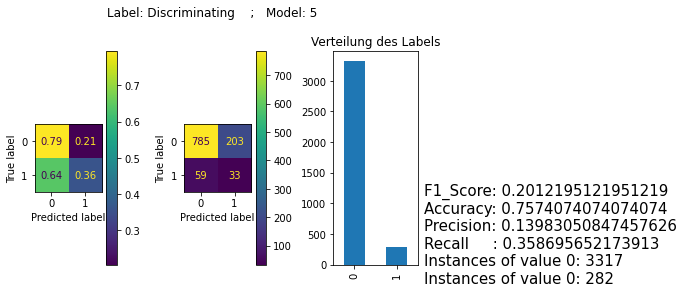

--------------
--------------
--------------
Label:    Inappropriate
--------------
2:
Confusion Matrix: 



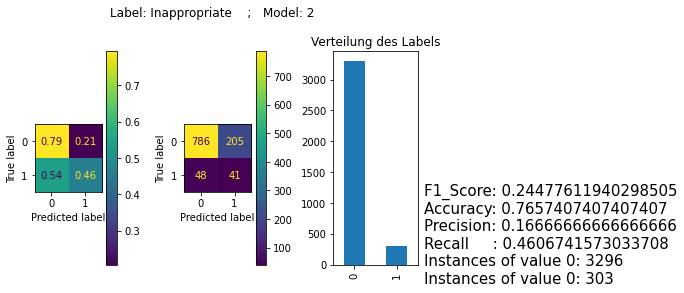

--------------
--------------
--------------
Label:    Inappropriate
--------------
3:
Confusion Matrix: 



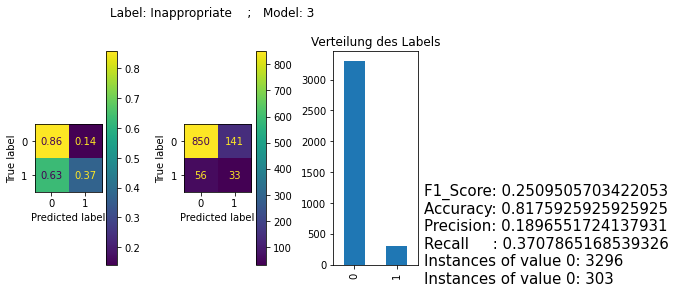

--------------
--------------
--------------
Label:    Inappropriate
--------------
4:
Confusion Matrix: 



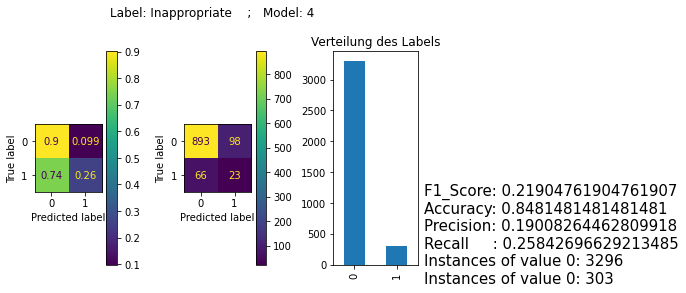

--------------
--------------
--------------
Label:    Inappropriate
--------------
5:
Confusion Matrix: 



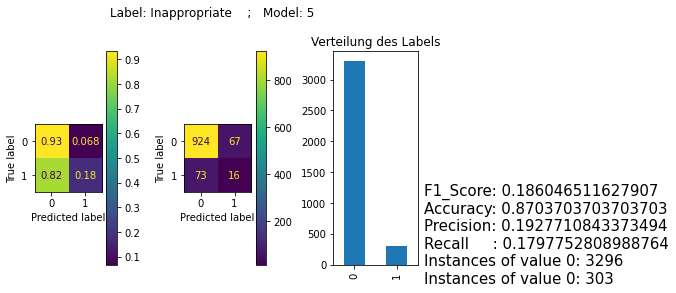

--------------
--------------
--------------
Label:    OffTopic
--------------
2:
Confusion Matrix: 



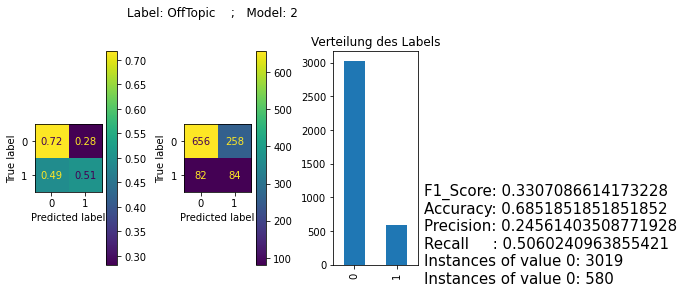

--------------
--------------
--------------
Label:    OffTopic
--------------
3:
Confusion Matrix: 



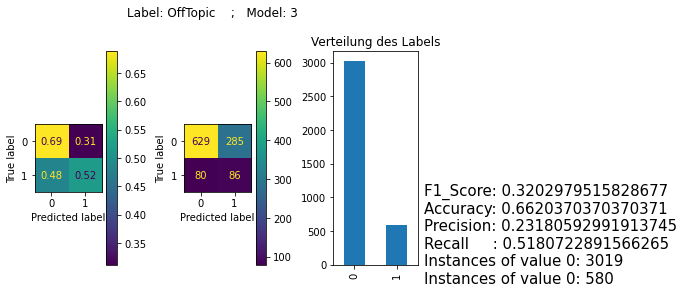

--------------
--------------
--------------
Label:    OffTopic
--------------
4:
Confusion Matrix: 



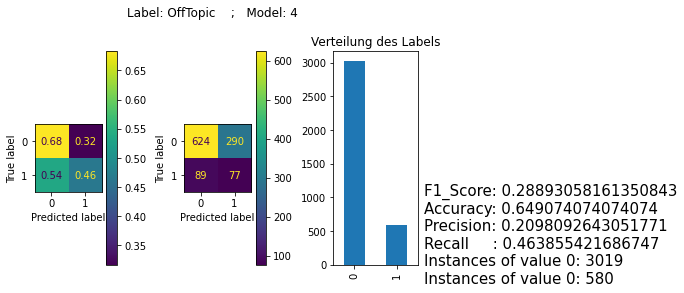

--------------
--------------
--------------
Label:    OffTopic
--------------
5:
Confusion Matrix: 



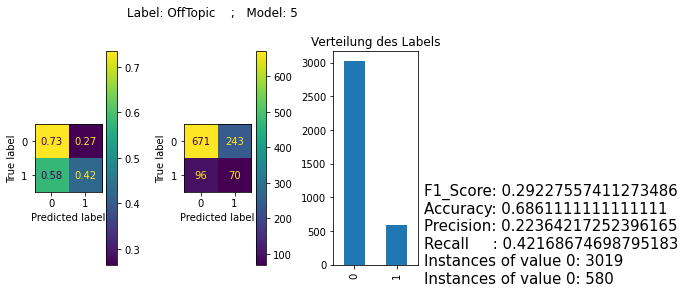

--------------
--------------
--------------
Label:    PersonalStories
--------------
2:
Confusion Matrix: 



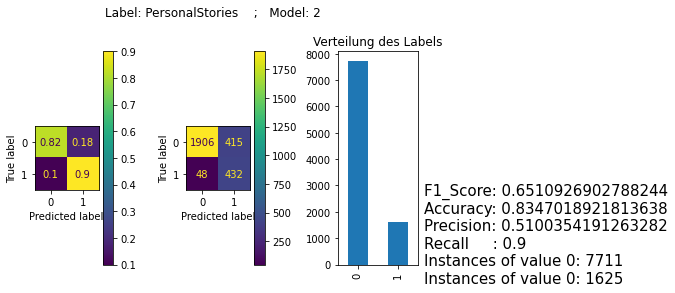

--------------
--------------
--------------
Label:    PersonalStories
--------------
3:
Confusion Matrix: 



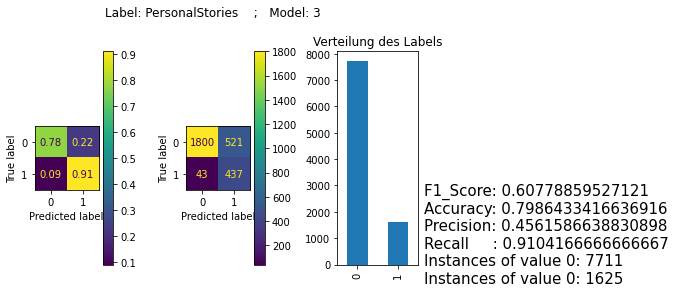

--------------
--------------
--------------
Label:    PersonalStories
--------------
4:
Confusion Matrix: 



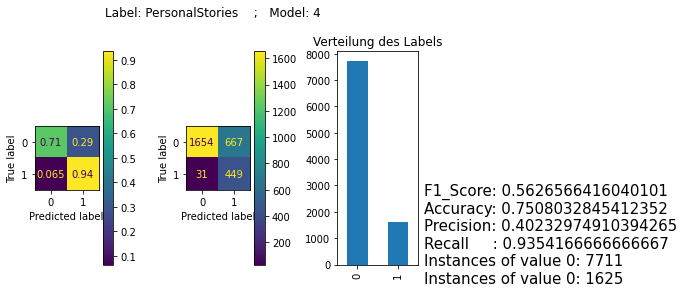

--------------
--------------
--------------
Label:    PersonalStories
--------------
5:
Confusion Matrix: 



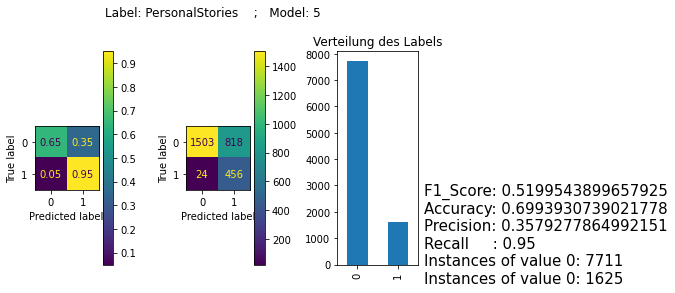

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
2:
Confusion Matrix: 



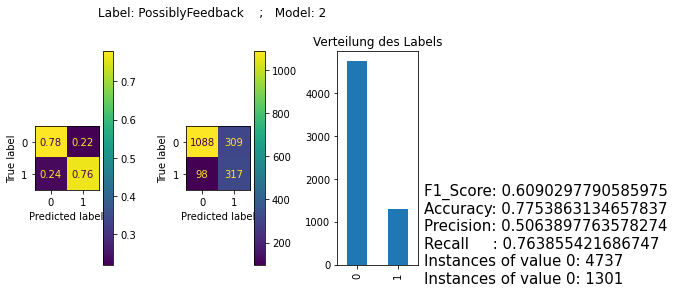

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
3:
Confusion Matrix: 



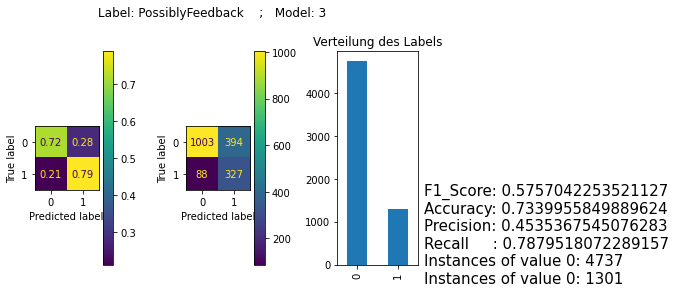

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
4:
Confusion Matrix: 



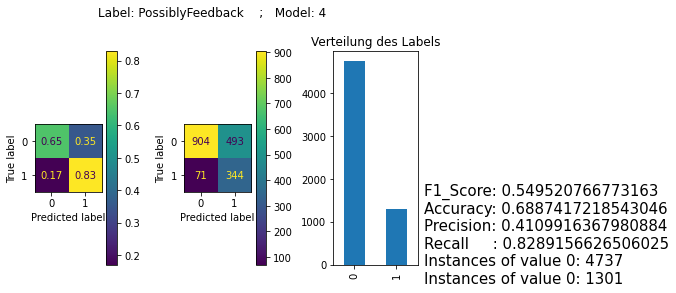

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
5:
Confusion Matrix: 



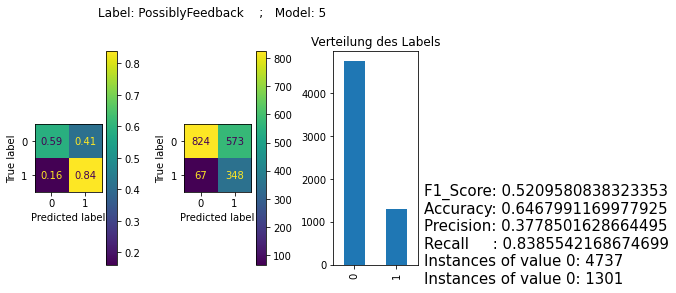

--------------
--------------
--------------
Label:    SentimentNegative
--------------
2:
Confusion Matrix: 



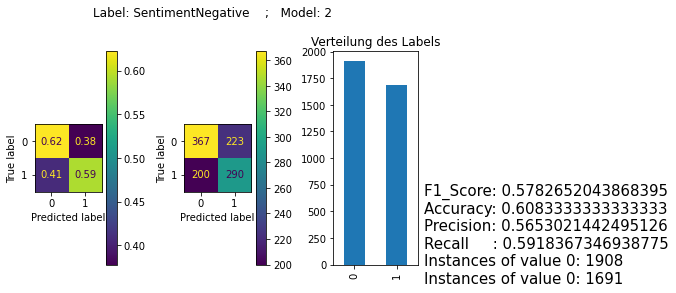

--------------
--------------
--------------
Label:    SentimentNegative
--------------
3:
Confusion Matrix: 



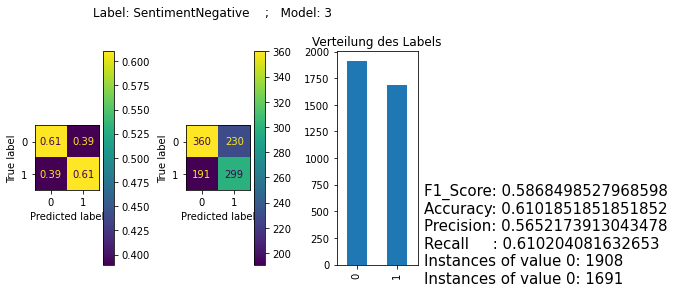

--------------
--------------
--------------
Label:    SentimentNegative
--------------
4:
Confusion Matrix: 



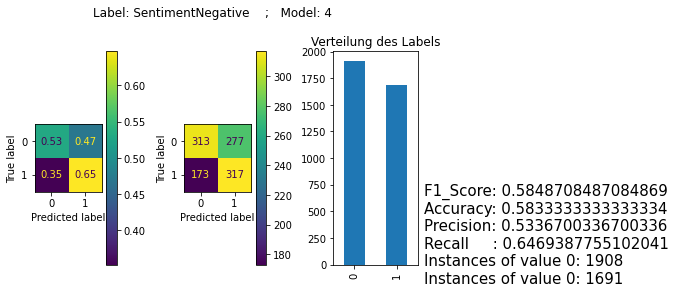

--------------
--------------
--------------
Label:    SentimentNegative
--------------
5:
Confusion Matrix: 



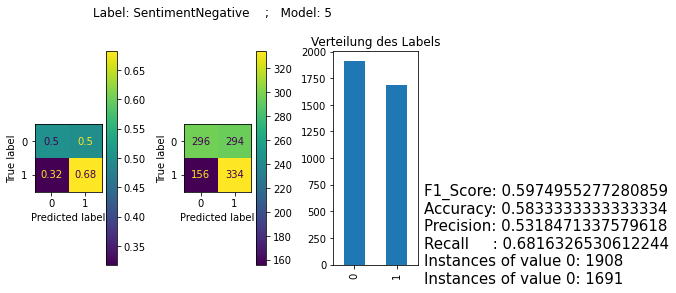

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
2:
Confusion Matrix: 



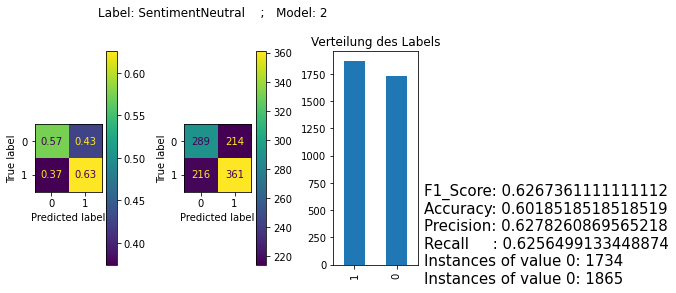

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
3:
Confusion Matrix: 



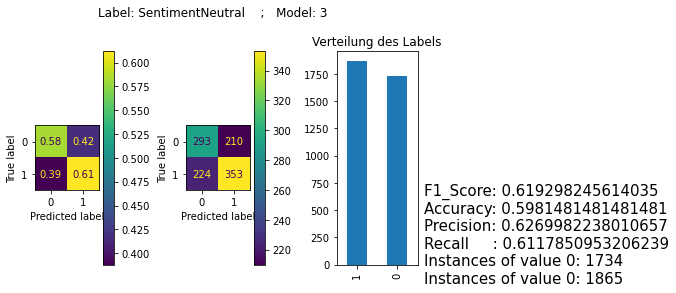

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
4:
Confusion Matrix: 



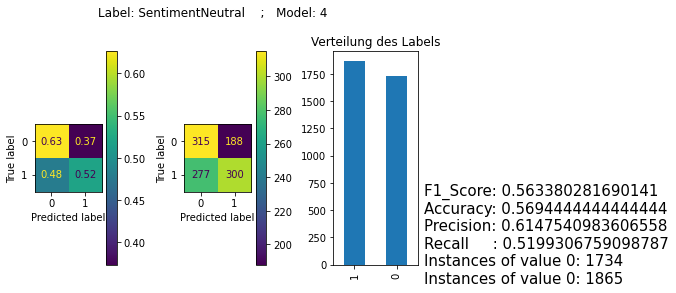

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
5:
Confusion Matrix: 



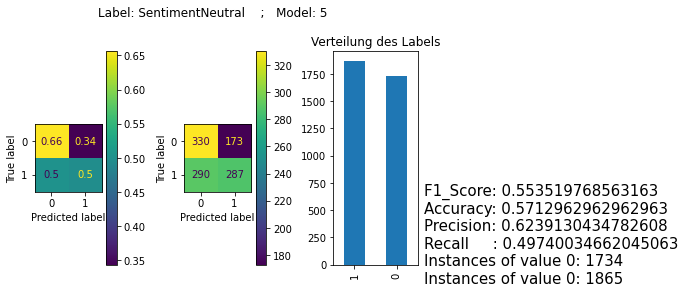

--------------


In [ ]:

# Versuch 1:
# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
for label in labels:
    # Table_Join holen:
    joined_table = getLabeledPart(label)

    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table["Text"], joined_table["Value"],
                                                                          test_size=0.3,
                                                                          random_state=1234, shuffle=True)
    # Text zu Wort-Vektoren umwandeln:
    text_train = text_train.apply(lambda x: nlp(x).vector)
    text_test  = text_test.apply(lambda x: nlp(x).vector)

    #Handling mapping irregularities:
    for index, element in enumerate(text_train):
        if (element.shape != (300,)):
            print(index, element.shape)
            text_train.iat[index]= text_train.iat[index].reshape((300,))

    for index, element in enumerate(text_test):
        if (element.shape != (300,)):
            print(index, element.shape)
            text_test.iat[index]= text_test.iat[index].reshape((300,))

    #Umwandeln in numpy-Matrizen:
    text_train= np.column_stack(text_train)
    text_test = np.column_stack(text_test)

    # model_names = ["Support_Vector_Column_Dual","Support_Vector_Column_Primal","Support_Vector_Column_RBF_Kernel","Support_Vector_Column_Sigmoid_Kernel","Support_Vector_Column_Polynomial_Kernel"]
    # models = [svm.LinearSVC(class_weight = "balanced"),
    #           svm.LinearSVC(dual= False,class_weight = "balanced"),
    #           svm.SVC(class_weight = "balanced"),
    #           svm.SVC(kernel="sigmoid",class_weight = "balanced"),
    #           svm.SVC(kernel="poly",degree=3,class_weight = "balanced")]
    model_names = ["2","3","4","5"]
    models = [svm.SVC(kernel="poly",degree=2,class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=4,class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=5,class_weight = "balanced")]

    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train.transpose(),label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test.transpose())

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        val_counts = joined_table["Value"].value_counts()

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))


        print("--------------")
        print("{}:".format(model_name))

        print("Confusion Matrix: \n")
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                "Instances of value 0: "+str(val_counts[0]) +"\n"+ "Instances of value 0: "+str(val_counts[1]))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()
        plt.show()


        print("--------------")




C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Sanitiy\AppData\Local\Temp\ipykernel_5832\1392655703.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3)


--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


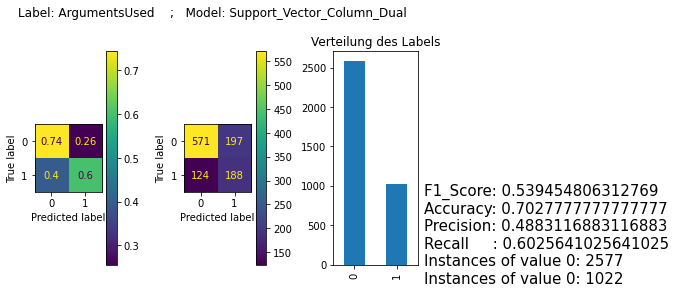

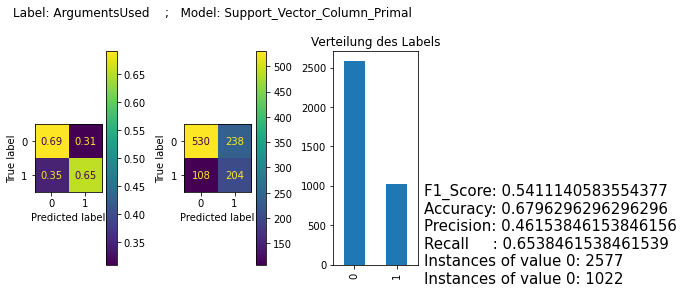

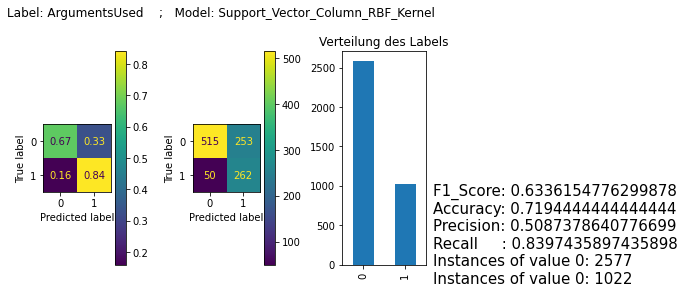

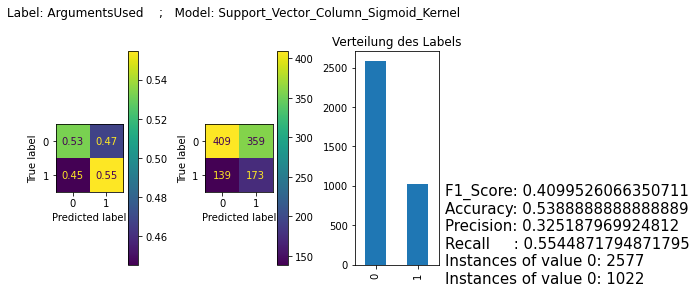

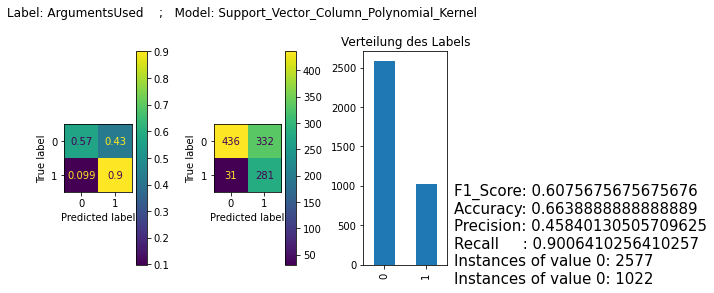

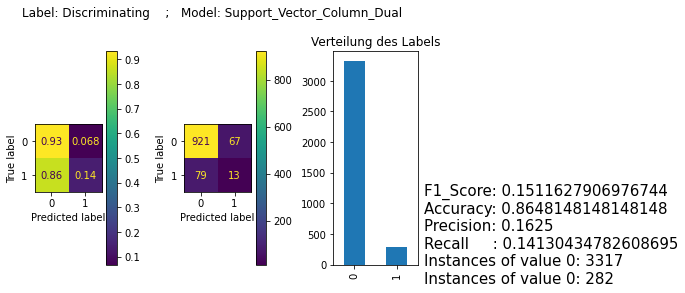

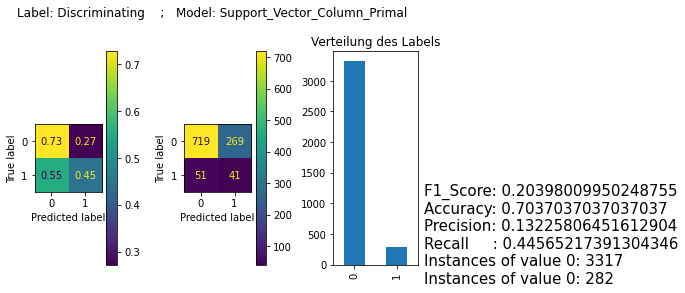

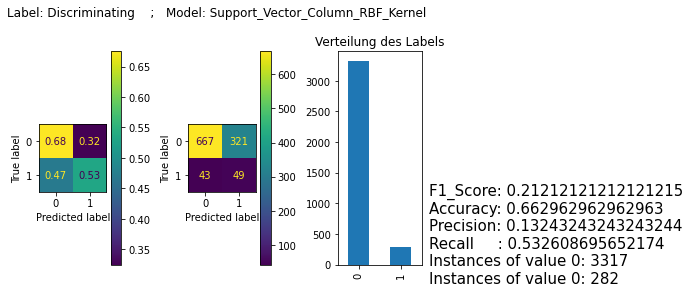

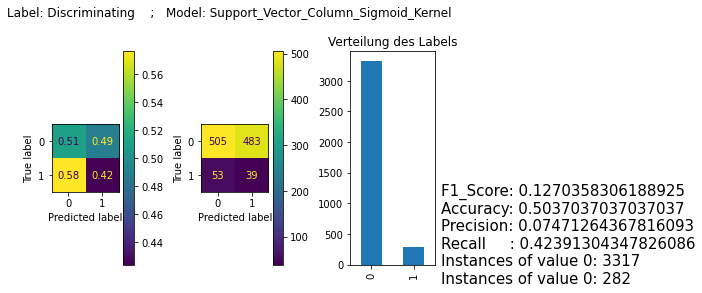

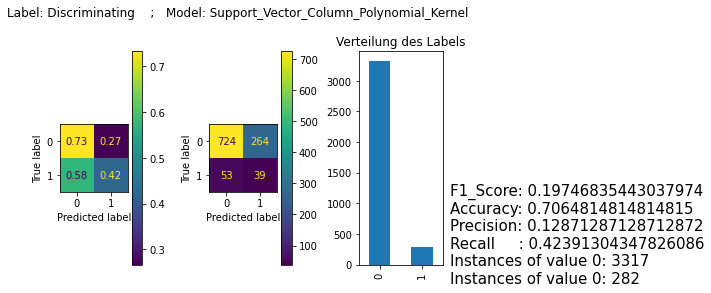

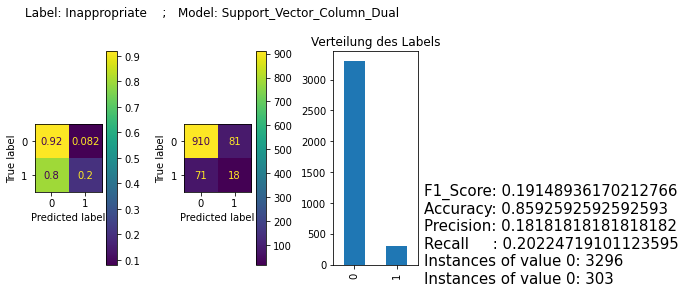

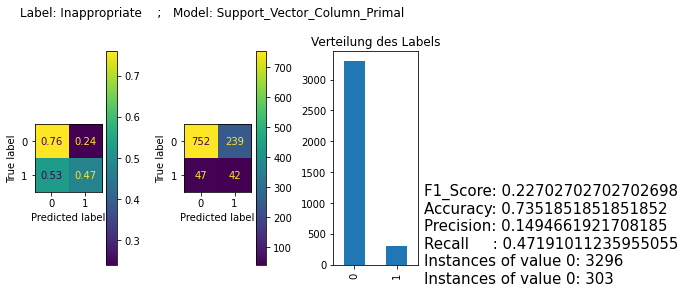

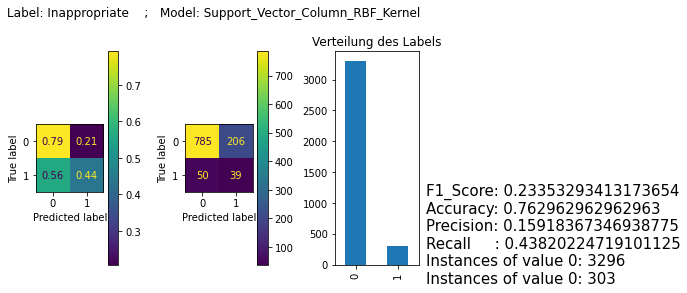

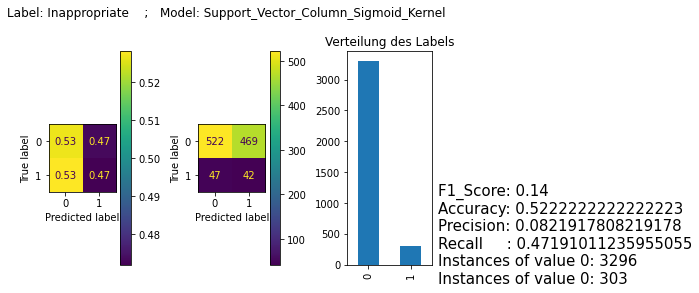

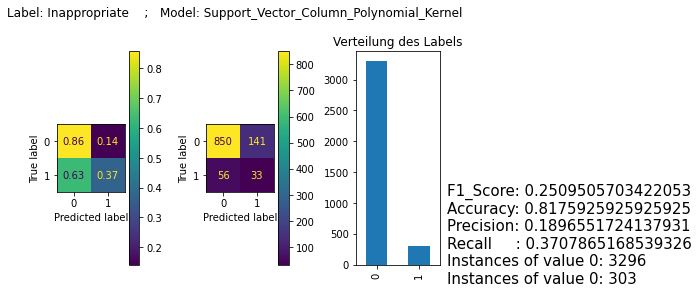

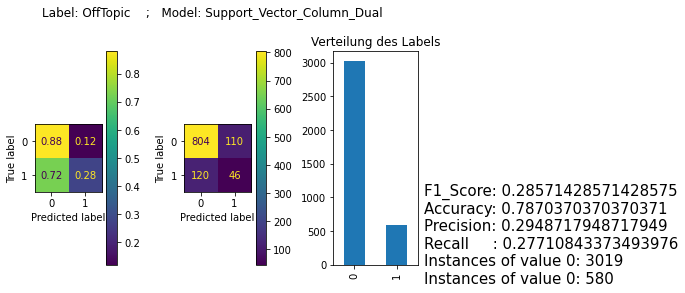

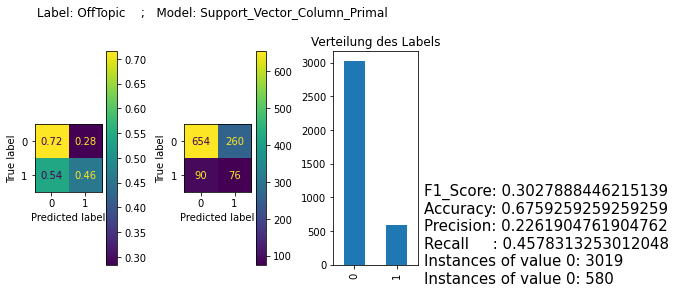

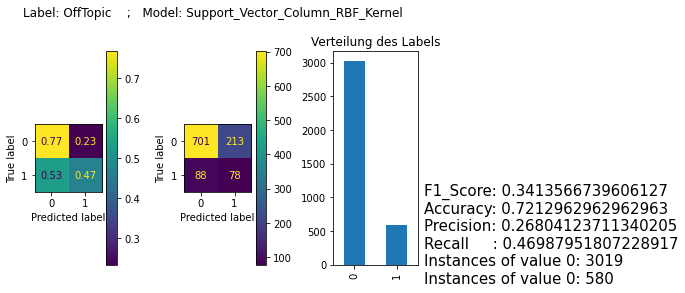

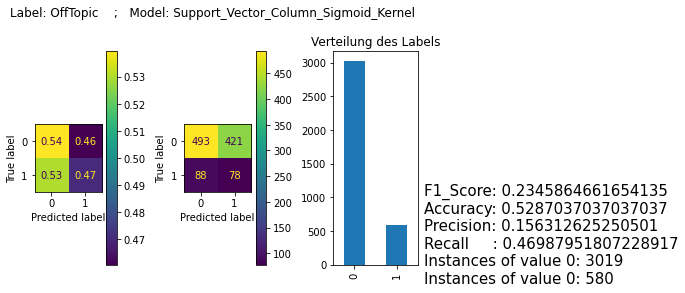

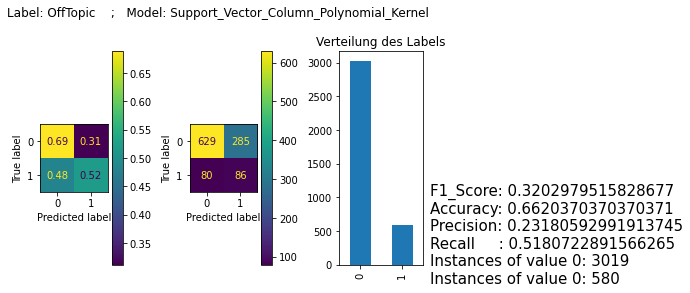

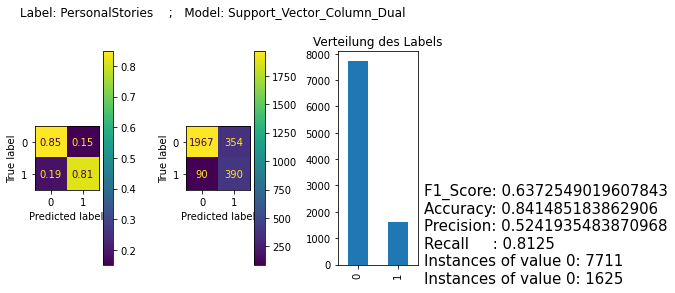

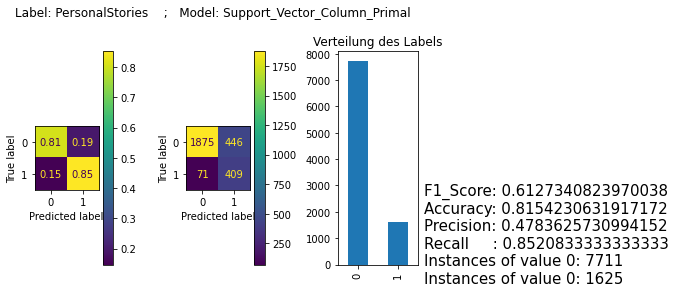

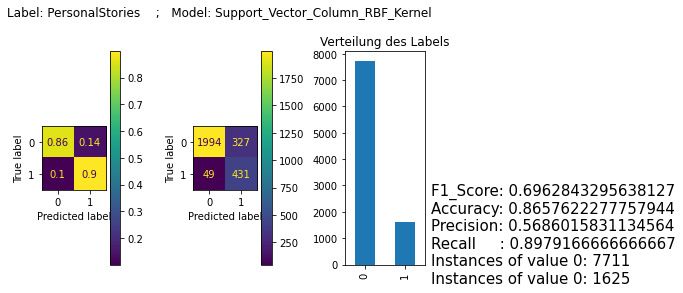

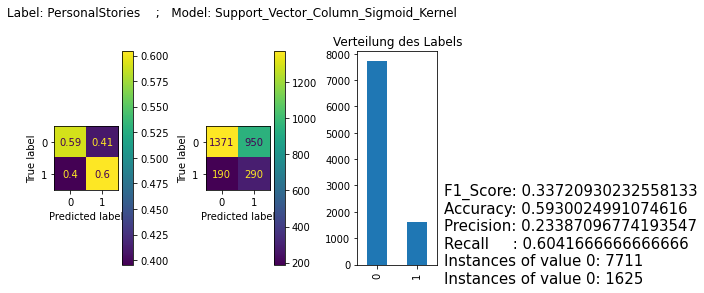

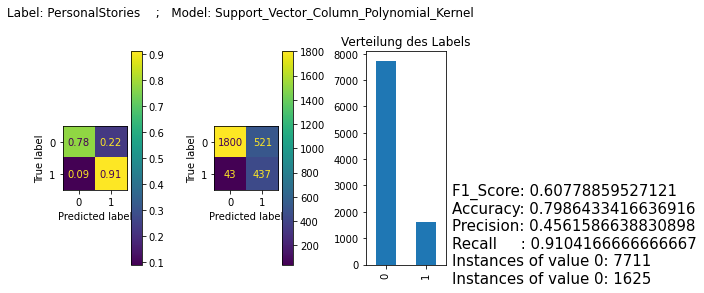

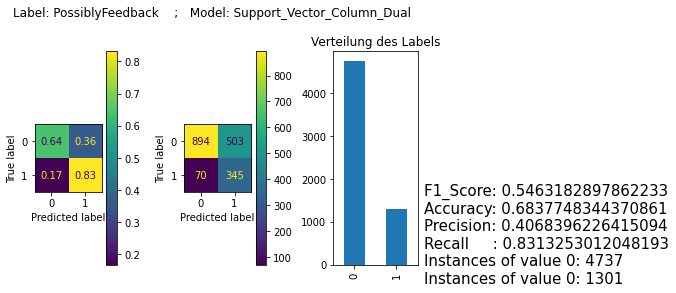

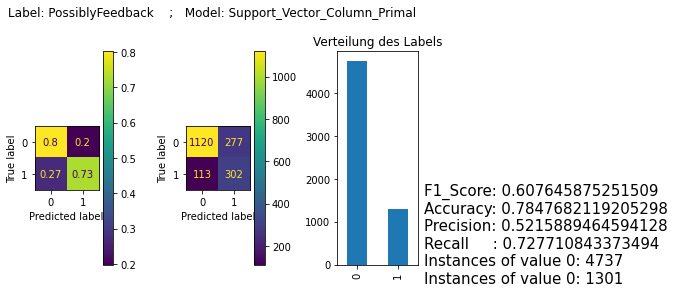

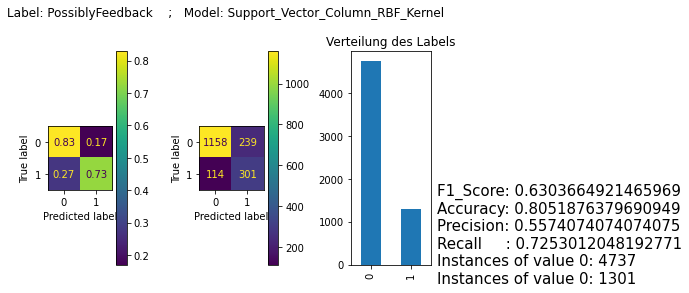

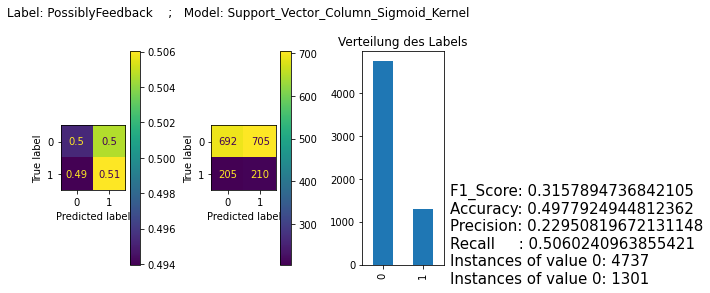

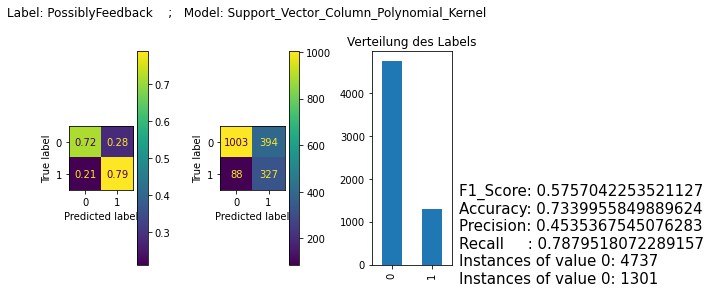

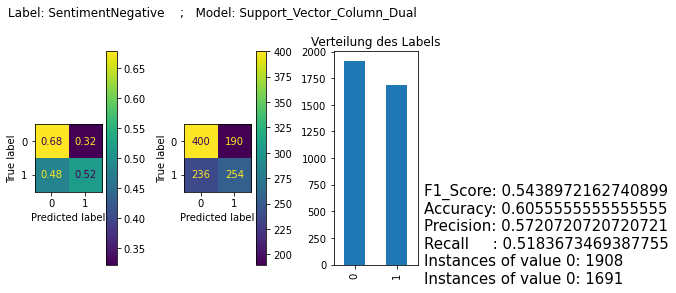

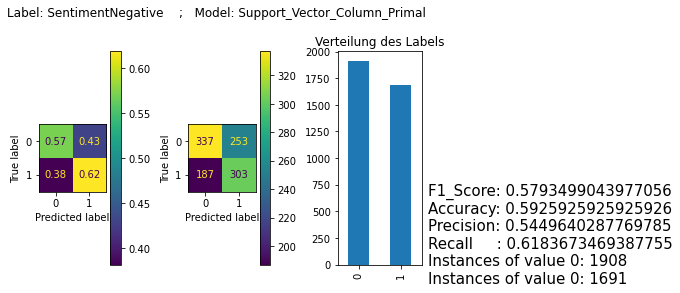

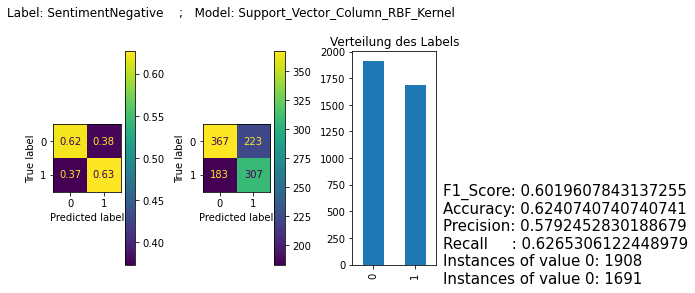

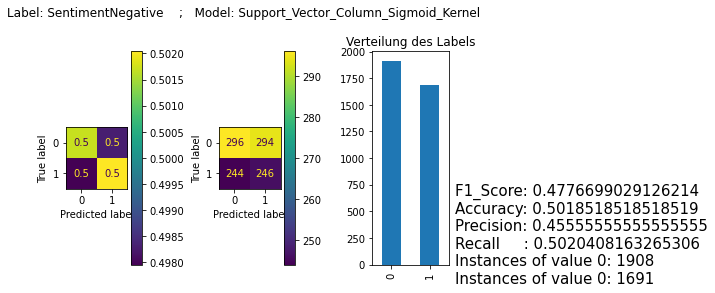

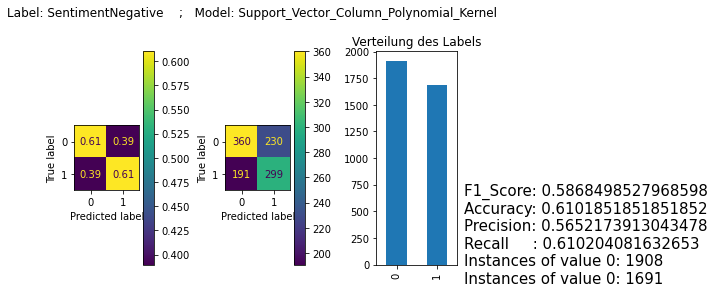

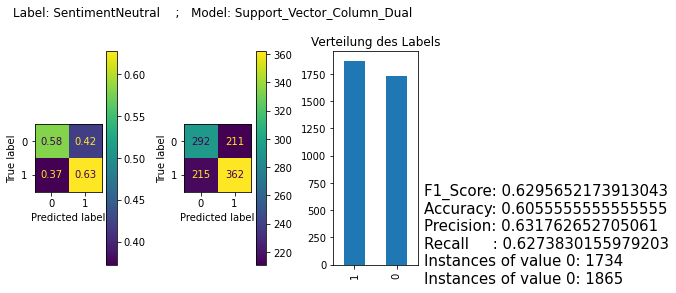

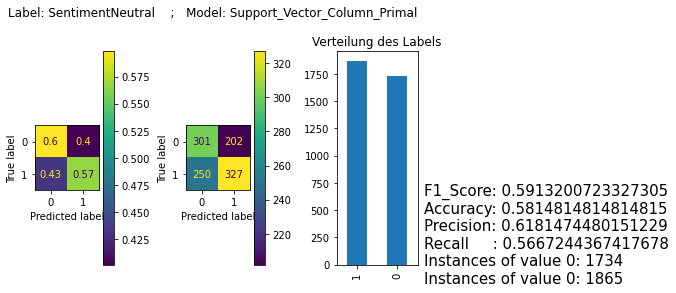

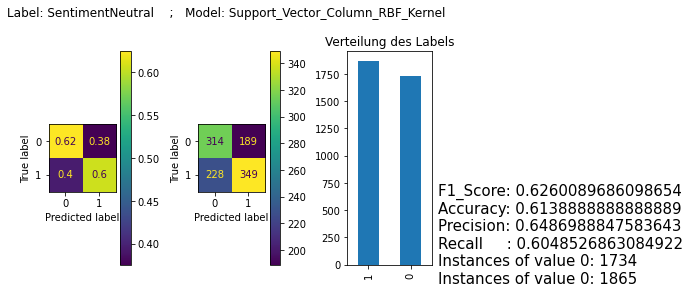

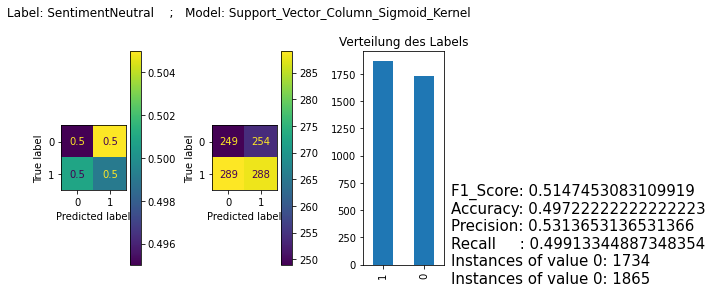

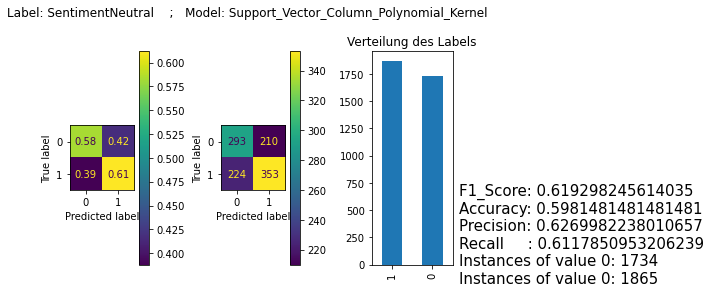

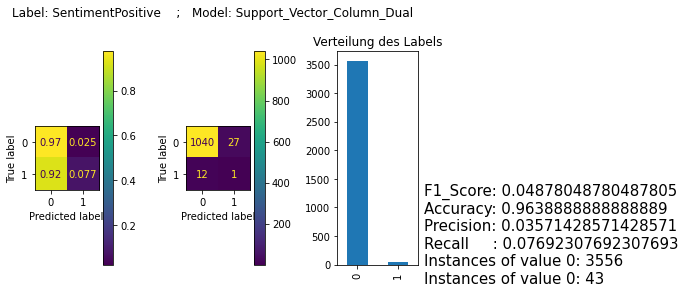

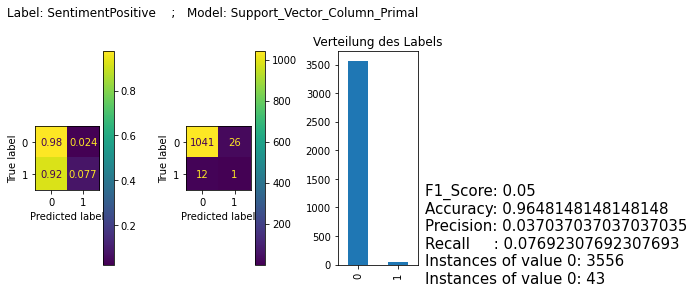

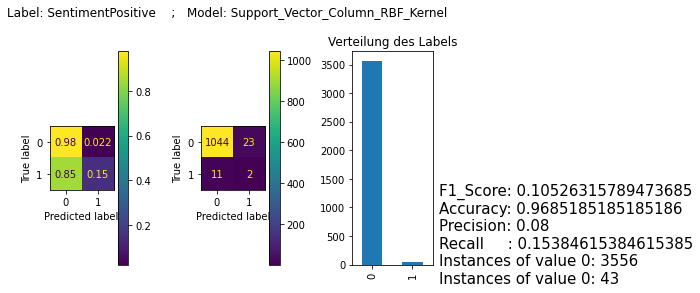

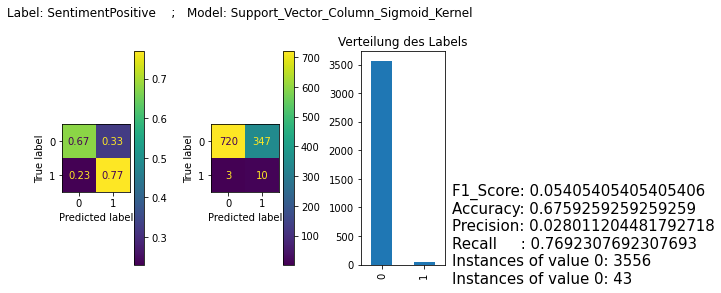

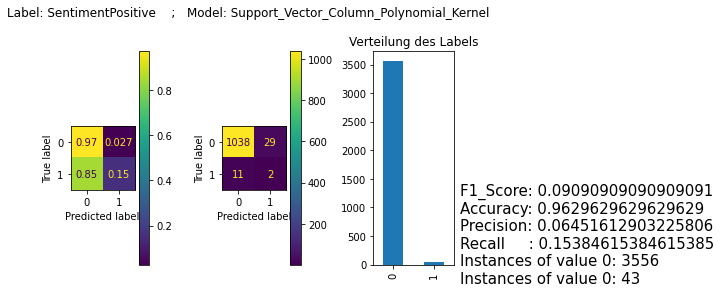

In [13]:
# Versuch 1 Erweiterung: Direktes Speichern als PDF statt als Output-Text

from matplotlib.backends.backend_pdf import PdfPages

# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
pdf_out = PdfPages('Training Results ..._lg, weighted SVC.pdf')
for label in labels:
    # Table_Join holen:
    joined_table = getLabeledPart(label)

    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table["Text"], joined_table["Value"],
                                                                      test_size=0.3,
                                                                      random_state=1234, shuffle=True)
    # Text zu Wort-Vektoren umwandeln:
    text_train = text_train.apply(lambda x: nlp(x).vector)
    text_test  = text_test.apply(lambda x: nlp(x).vector)

    #Handling mapping irregularities:
    for index, element in enumerate(text_train):
        if (element.shape != (300,)):
            print(index, element.shape)
            text_train.iat[index]= text_train.iat[index].reshape((300,))

    for index, element in enumerate(text_test):
        if (element.shape != (300,)):
            print(index, element.shape)
            text_test.iat[index]= text_test.iat[index].reshape((300,))

    #Umwandeln in numpy-Matrizen:
    text_train= np.column_stack(text_train)
    text_test = np.column_stack(text_test)

    model_names = ["Support_Vector_Column_Dual","Support_Vector_Column_Primal","Support_Vector_Column_RBF_Kernel","Support_Vector_Column_Sigmoid_Kernel","Support_Vector_Column_Polynomial_Kernel"]
    models = [svm.LinearSVC(class_weight = "balanced"),
              svm.LinearSVC(dual= False,class_weight = "balanced"),
              svm.SVC(class_weight = "balanced"),
              svm.SVC(kernel="sigmoid",class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced")]


    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train.transpose(),label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test.transpose())

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        val_counts = joined_table["Value"].value_counts()

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))


        print("--------------")
        print("{}:".format(model_name))



        print("Confusion Matrix: \n")
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                 "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                 "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                 "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                 "Instances of value 0: "+str(val_counts[0]) +"\n"+ "Instances of value 0: "+str(val_counts[1]))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()
        pdf_out.savefig(fig,bbox_inches='tight')


        print("--------------")

pdf_out.close()





In [ ]:
# Versuch 3: ON_HOLD - Es gibt zu wenig positive Ausprägungen...
# Die Labels "SentimentNegative","SentimentNeutral" und "SentimentPositive" können als Ausprägungen eines einzelnen Labels interpretiert werden.
# Zu beachten ist hierbei allerdings, dass einige Posts mehrere dieser Labels gleichzeitig haben.
# Wir können also einen Regressor bauen für den 0 - Negativ, 1 - Neutral, 2 - Positiv bedeutet.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.



In [14]:
getLabeledPart("Inappropriate")

,Value,Text
ID_Post,,
3326,0,Top qualifizierte Leute verdienen auch viel.
5321,0,"Gott sei dank ist für sie eine Umfrage alles, ..."
5590,0,""" Die FPÖ wird aus allen Rohren schießen und d..."
6015,1,Weil es dein meisten Leuten verständlicherweis...
8213,0,Na wer weis was da vorgefallen ist...
...,...,...
1004115,0,Russland ist in wk1 vorzeirig ausgestiegen. ;-...
1004189,0,"Was tendenziell kein schlechter Tausch wäre, w..."
1004571,0,Was? Unsinn! Der Linguistik turn beschränkt si...
